# Import Libraries

In [1]:
import json
import os
from collections import defaultdict, Counter
import imagehash
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw,ImageFont, UnidentifiedImageError
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from itertools import combinations

In [2]:
np.random.seed(42)

# Setup Working dir

In [3]:
os.chdir("..")
# Set dataset paths
ROOT_DIR = os.getcwd()
print(ROOT_DIR)

LABEL_DIR = os.path.join(ROOT_DIR,"data", "bdd100k_labels_release", "bdd100k", "labels")
IMAGE_DIR = os.path.join(ROOT_DIR,"data","bdd100k_images_100k", "bdd100k","images", "100k")

# --- Paths (assuming ROOT_DIR is set) ---
RESULTS_DIR = os.path.join(ROOT_DIR, "results")
os.makedirs(RESULTS_DIR, exist_ok=True)

IMAGE_DIR_TRAIN = os.path.join(IMAGE_DIR, "train")  # adjust if needed
IMAGE_DIR_VAL = os.path.join(IMAGE_DIR, "val")  # adjust if needed

/home/mehul/bdd_od


# Load label files

In [4]:
%%time

# Train 
with open(os.path.join(LABEL_DIR, "bdd100k_labels_images_train.json")) as f:
    train_labels = json.load(f)
    
# Validation
with open(os.path.join(LABEL_DIR, "bdd100k_labels_images_val.json")) as f:
    val_labels = json.load(f)

CPU times: user 20.3 s, sys: 23.3 s, total: 43.6 s
Wall time: 43.3 s


In [5]:
all_train_images = [ann["name"] for ann in train_labels]
all_val_images = [ann["name"] for ann in val_labels]

In [6]:
# Print one sample to check the structure
train_labels[0]

{'name': '0000f77c-6257be58.jpg',
 'attributes': {'weather': 'clear',
  'scene': 'city street',
  'timeofday': 'daytime'},
 'timestamp': 10000,
 'labels': [{'category': 'traffic light',
   'attributes': {'occluded': False,
    'truncated': False,
    'trafficLightColor': 'green'},
   'manualShape': True,
   'manualAttributes': True,
   'box2d': {'x1': 1125.902264,
    'y1': 133.184488,
    'x2': 1156.978645,
    'y2': 210.875445},
   'id': 0},
  {'category': 'traffic light',
   'attributes': {'occluded': False,
    'truncated': False,
    'trafficLightColor': 'green'},
   'manualShape': True,
   'manualAttributes': True,
   'box2d': {'x1': 1156.978645,
    'y1': 136.637417,
    'x2': 1191.50796,
    'y2': 210.875443},
   'id': 1},
  {'category': 'traffic sign',
   'attributes': {'occluded': False,
    'truncated': False,
    'trafficLightColor': 'none'},
   'manualShape': True,
   'manualAttributes': True,
   'box2d': {'x1': 1101.731743,
    'y1': 211.122087,
    'x2': 1170.79037,
    

In [7]:
train_labels[0].keys()

dict_keys(['name', 'attributes', 'timestamp', 'labels'])

In [8]:
train_labels[0]['name'],train_labels[0]['attributes'], train_labels[0]['timestamp']

('0000f77c-6257be58.jpg',
 {'weather': 'clear', 'scene': 'city street', 'timeofday': 'daytime'},
 10000)

# Check number of images for train and validation|

In [9]:

# --- Dataset counts ---
num_train = len(train_labels)
num_val = len(val_labels)
num_total = num_train + num_val  # BDD100K usually has test split separately, but test labels may not be public


print("Dataset Size:")
print(f"Total Images: {num_total}")
print(f"Train: {num_train}")
print(f"Validation: {num_val}")

Dataset Size:
Total Images: 79863
Train: 69863
Validation: 10000


In [10]:
# --- Optional: Save one sample image with boxes ---
def show_sample_with_boxes(annotation, split="train", save_path=None):
    image_path = os.path.join(IMAGE_DIR, split, annotation["name"])
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return None

    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)

    for label in annotation.get("labels", []):
        if "box2d" in label:
            box = label["box2d"]
            x1, y1, x2, y2 = box["x1"], box["y1"], box["x2"], box["y2"]
            category = label.get("category", "N/A")
            draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
            draw.text((x1, y1), category, fill="yellow")

    if save_path:
        image.save(save_path)
    return image

Sample image saved to /home/mehul/bdd_od/results/sample_image_train.jpg


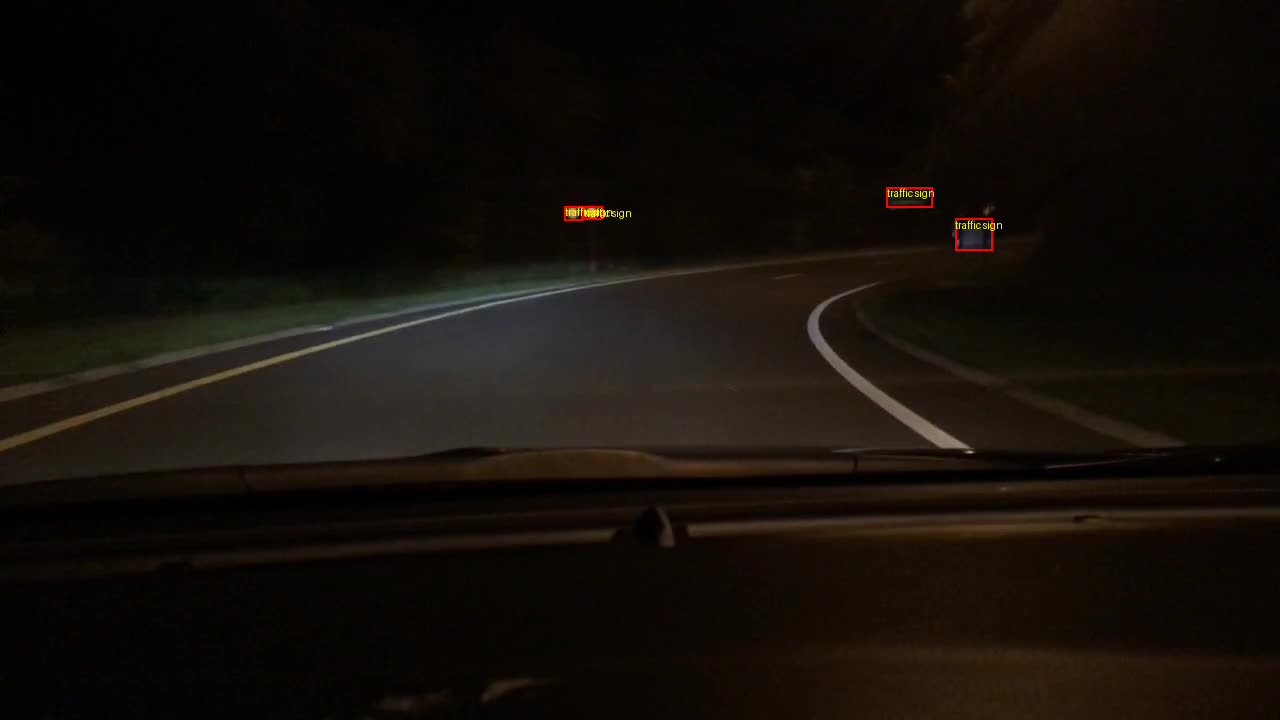

In [11]:
# Pick a random train image and save it
sample_annotation = np.random.choice(train_labels)
sample_save_path = os.path.join(RESULTS_DIR, "sample_image_train.jpg")
img = show_sample_with_boxes(sample_annotation, split="train", save_path=sample_save_path)

print(f"Sample image saved to {sample_save_path}")

img

Sample image saved to /home/mehul/bdd_od/results/sample_image_val.jpg


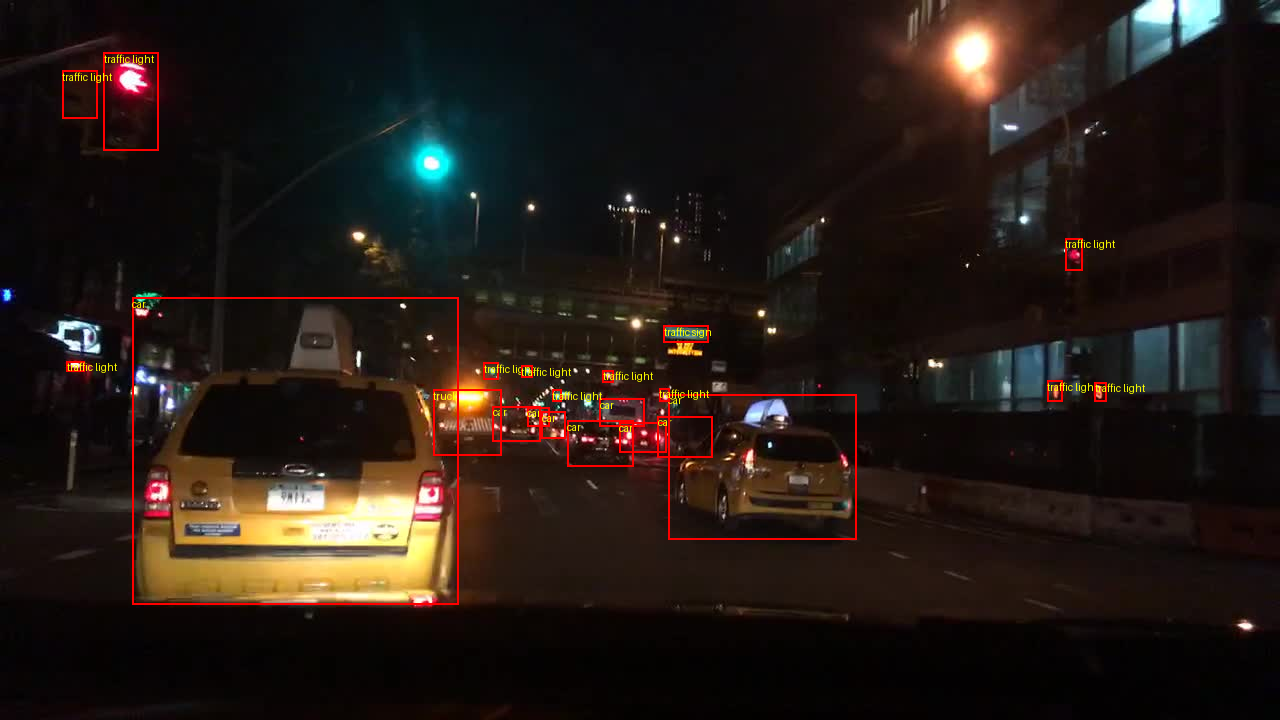

In [12]:
# Pick a random train image and save it
sample_annotation = np.random.choice(val_labels)
sample_save_path = os.path.join(RESULTS_DIR, "sample_image_val.jpg")
img = show_sample_with_boxes(sample_annotation, split="val", save_path=sample_save_path)

print(f"Sample image saved to {sample_save_path}")

img

In [13]:
# --- Sample a subset of images for fast stats ---
sample_train_images = np.random.choice(all_train_images, size=min(1000, len(all_train_images)), replace=False)
sample_val_images = np.random.choice(all_val_images, size=min(1000, len(all_val_images)), replace=False)

In [14]:
# Width and Heights Analysis

# train data

widths, heights = [], []

for img_name in sample_train_images:
    img_path = os.path.join(IMAGE_DIR_TRAIN, img_name)
    if os.path.exists(img_path):
        img = Image.open(img_path)
        w, h = img.size
        widths.append(w)
        heights.append(h)

widths = np.array(widths)
heights = np.array(heights)

# --- Compute statistics ---
stats = {
    "width_mean": widths.mean(),
    "width_std": widths.std(),
    "width_min": widths.min(),
    "width_max": widths.max(),
    "height_mean": heights.mean(),
    "height_std": heights.std(),
    "height_min": heights.min(),
    "height_max": heights.max()
}

print("Image Dimension Stats:", stats)
print(f"All images have the same size: {widths[0]} x {heights[0]}")

Image Dimension Stats: {'width_mean': np.float64(1280.0), 'width_std': np.float64(0.0), 'width_min': np.int64(1280), 'width_max': np.int64(1280), 'height_mean': np.float64(720.0), 'height_std': np.float64(0.0), 'height_min': np.int64(720), 'height_max': np.int64(720)}
All images have the same size: 1280 x 720


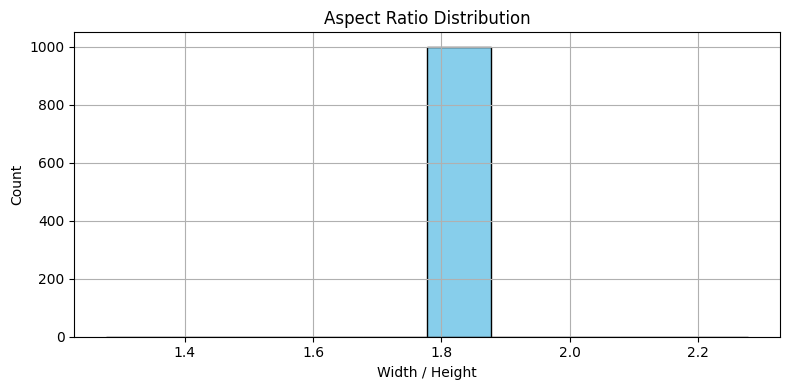

In [15]:
aspect_ratios = widths / heights

plt.figure(figsize=(8,4))
plt.hist(aspect_ratios, bins=10, color='skyblue', edgecolor='black')
plt.title("Aspect Ratio Distribution")
plt.xlabel("Width / Height")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "aspect_ratio_hist.png"))
plt.show()


In [16]:
# Val data

widths, heights = [], []

for img_name in sample_val_images:
    img_path = os.path.join(IMAGE_DIR_VAL, img_name)
    if os.path.exists(img_path):
        img = Image.open(img_path)
        w, h = img.size
        widths.append(w)
        heights.append(h)

widths = np.array(widths)
heights = np.array(heights)

# --- Compute statistics ---
stats = {
    "width_mean": widths.mean(),
    "width_std": widths.std(),
    "width_min": widths.min(),
    "width_max": widths.max(),
    "height_mean": heights.mean(),
    "height_std": heights.std(),
    "height_min": heights.min(),
    "height_max": heights.max()
}

print("Image Dimension Stats:", stats)
print(f"All images have the same size: {widths[0]} x {heights[0]}")

Image Dimension Stats: {'width_mean': np.float64(1280.0), 'width_std': np.float64(0.0), 'width_min': np.int64(1280), 'width_max': np.int64(1280), 'height_mean': np.float64(720.0), 'height_std': np.float64(0.0), 'height_min': np.int64(720), 'height_max': np.int64(720)}
All images have the same size: 1280 x 720


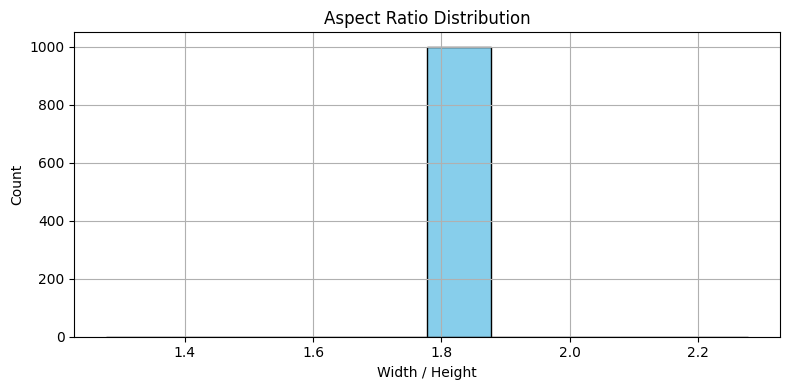

In [17]:
aspect_ratios = widths / heights

plt.figure(figsize=(8,4))
plt.hist(aspect_ratios, bins=10, color='skyblue', edgecolor='black')
plt.title("Aspect Ratio Distribution")
plt.xlabel("Width / Height")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "aspect_ratio_hist_val.png"))
plt.show()


# Sample Grid for train and val

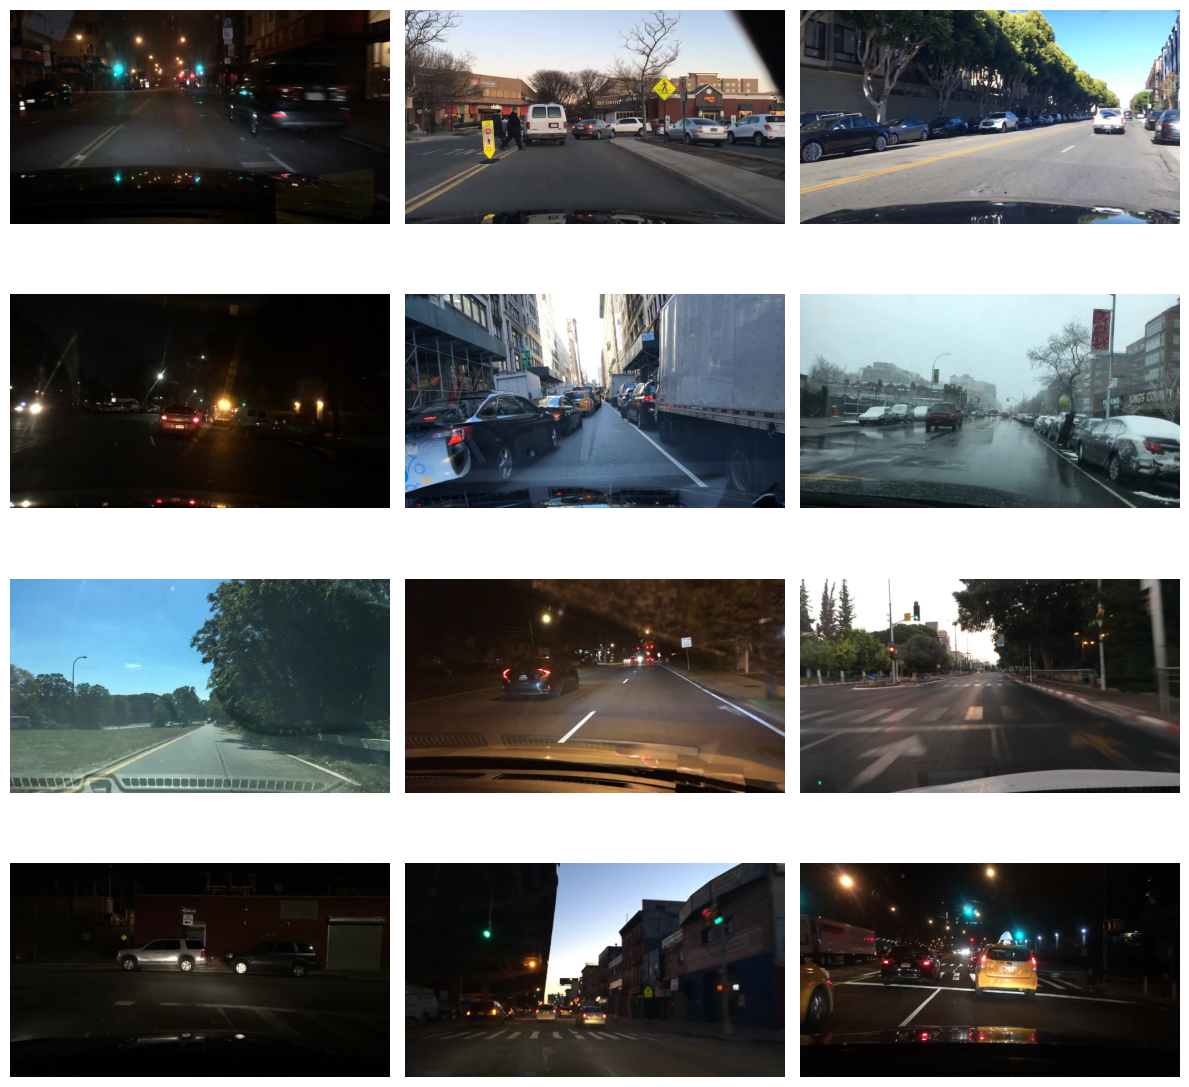

In [18]:
# --- Sample image grid ---
plt.figure(figsize=(12,12))
grid_sample = np.random.choice(all_train_images, size=min(12, len(all_train_images)), replace=False)
for i, img_name in enumerate(grid_sample):
    img = Image.open(os.path.join(IMAGE_DIR_TRAIN, img_name))
    plt.subplot(4,3,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "sample_images_grid.png"))
plt.show()

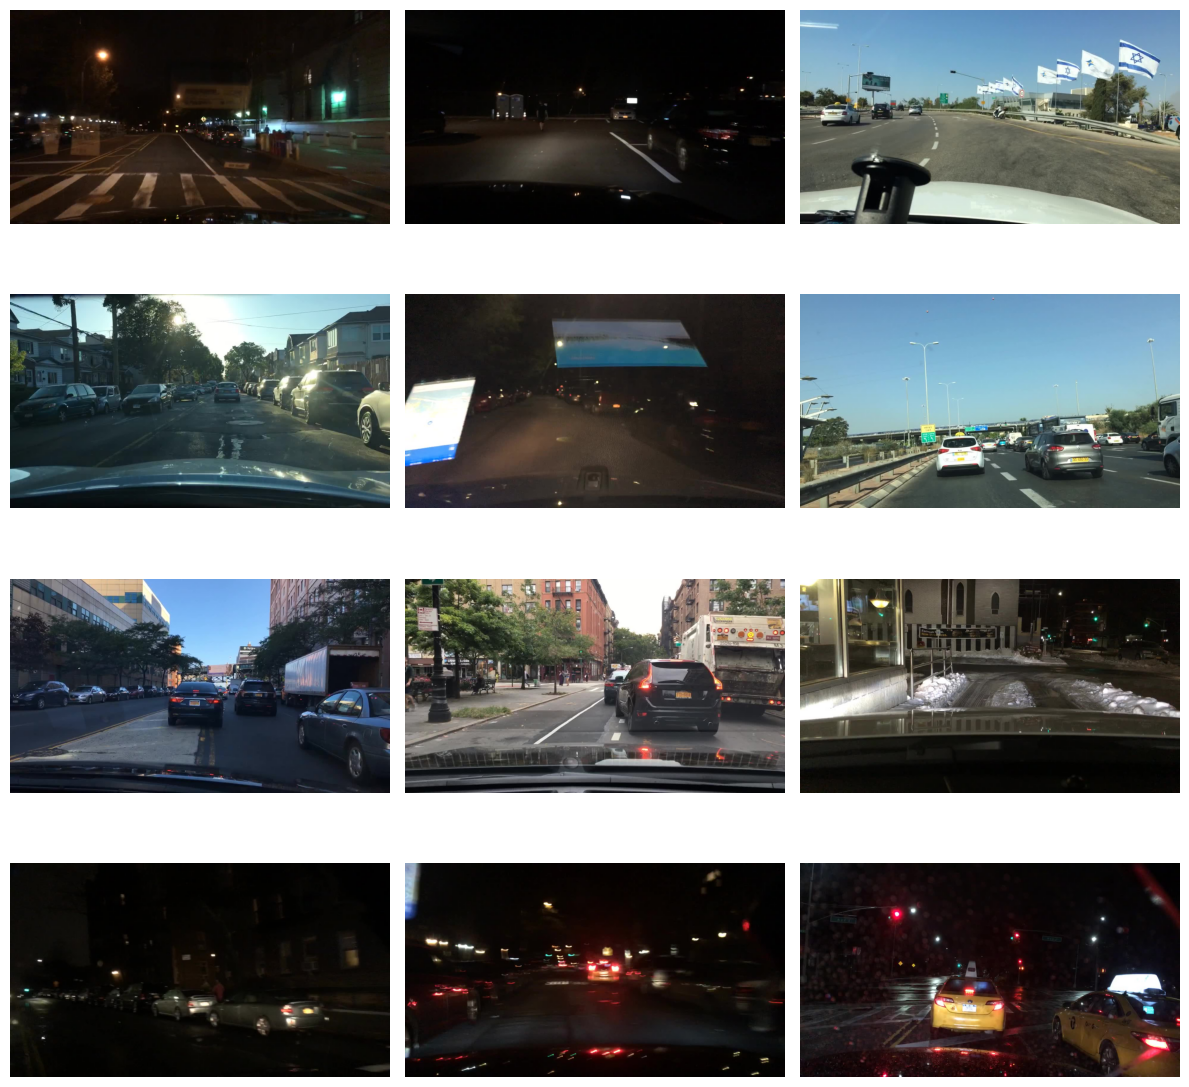

In [19]:
# --- Sample image grid ---
plt.figure(figsize=(12,12))
grid_sample = np.random.choice(all_val_images, size=min(12, len(all_train_images)), replace=False)
for i, img_name in enumerate(grid_sample):
    img = Image.open(os.path.join(IMAGE_DIR_VAL, img_name))
    plt.subplot(4,3,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "sample_images_grid_val.png"))
plt.show()

# Brightness and Constrast Analysis 

Brightness & Contrast Stats: {'brightness_mean': np.float64(0.29065124133646514), 'brightness_std': np.float64(0.15406220180501412), 'contrast_mean': np.float64(0.2032932397805129), 'contrast_std': np.float64(0.06794078514595792)}


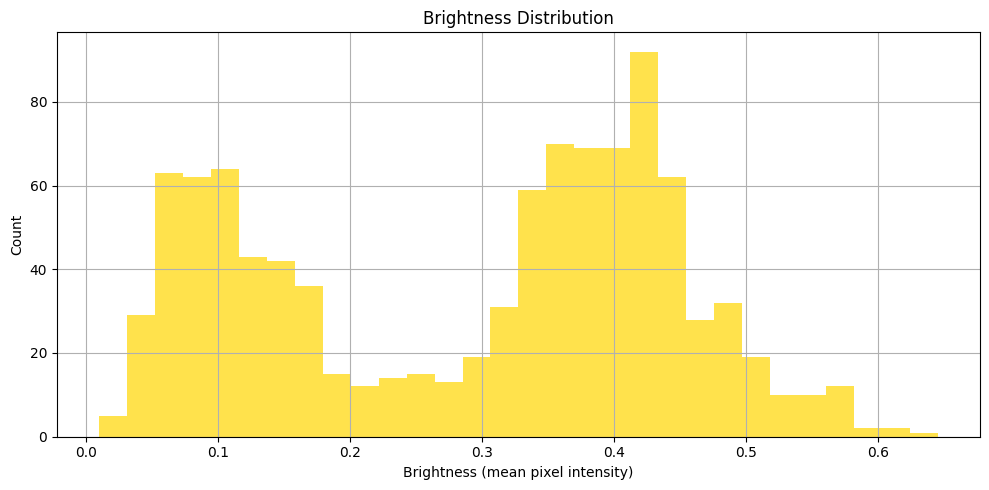

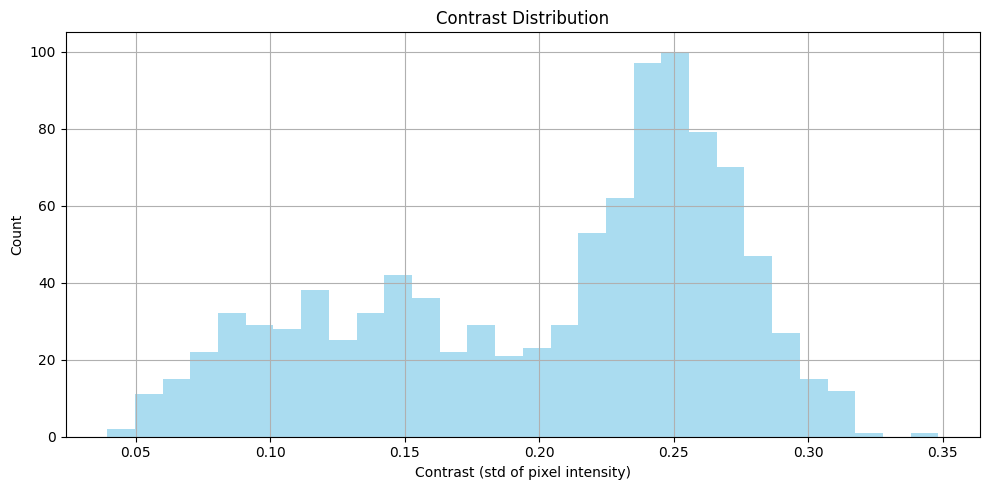

In [20]:
# Sample subset of images

sample_size = min(1000, len(all_train_images))
sample_images = np.random.choice(all_train_images, size=sample_size, replace=False)

brightness_list = []
contrast_list = []

# --- Compute brightness and contrast ---
for img_name in sample_images:
    img_path = os.path.join(IMAGE_DIR_TRAIN, img_name)
    if os.path.exists(img_path):
        img = Image.open(img_path).convert("RGB")
        img_array = np.array(img) / 255.0  # normalize 0-1
        # Brightness as mean intensity
        brightness = img_array.mean()
        # Contrast as std of intensity
        contrast = img_array.std()
        brightness_list.append(brightness)
        contrast_list.append(contrast)

brightness_array = np.array(brightness_list)
contrast_array = np.array(contrast_list)

# --- Statistics ---
stats = {
    "brightness_mean": brightness_array.mean(),
    "brightness_std": brightness_array.std(),
    "contrast_mean": contrast_array.mean(),
    "contrast_std": contrast_array.std()
}

print("Brightness & Contrast Stats:", stats)

# --- Plot Brightness Histogram ---
plt.figure(figsize=(10,5))
plt.hist(brightness_array, bins=30, color='gold', alpha=0.7)
plt.title("Brightness Distribution")
plt.xlabel("Brightness (mean pixel intensity)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "brightness_hist.png"))
plt.show()

# --- Plot Contrast Histogram ---
plt.figure(figsize=(10,5))
plt.hist(contrast_array, bins=30, color='skyblue', alpha=0.7)
plt.title("Contrast Distribution")
plt.xlabel("Contrast (std of pixel intensity)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "contrast_hist.png"))
plt.show()

Brightness & Contrast Stats: {'brightness_mean': np.float64(0.280780017447633), 'brightness_std': np.float64(0.1563508142212691), 'contrast_mean': np.float64(0.19918857261130404), 'contrast_std': np.float64(0.06950950209901527)}


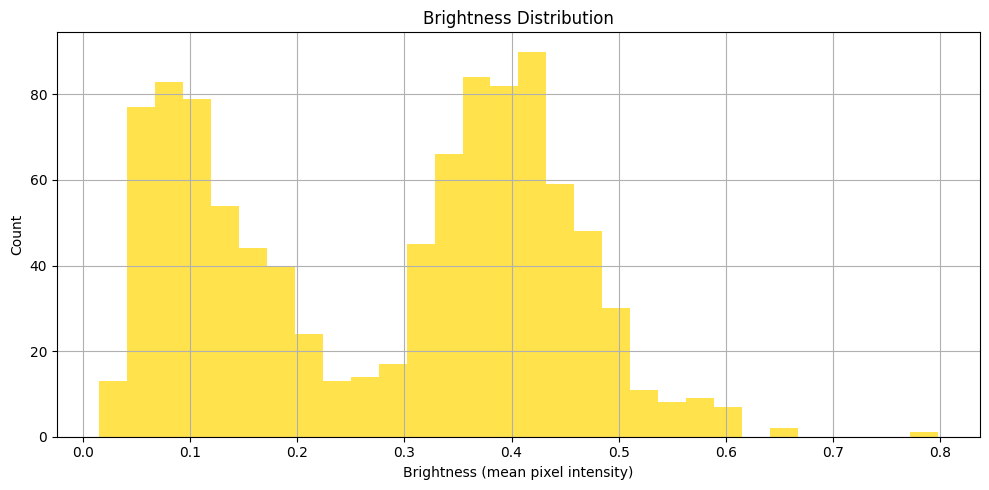

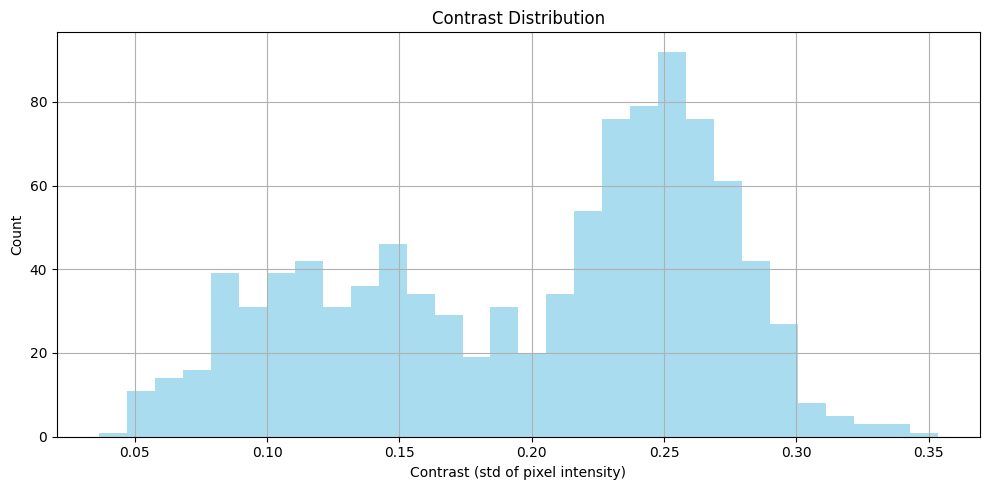

In [21]:
# Sample subset of images

sample_size = min(1000, len(all_val_images))
sample_images = np.random.choice(all_val_images, size=sample_size, replace=False)

brightness_list = []
contrast_list = []

# --- Compute brightness and contrast ---
for img_name in sample_images:
    img_path = os.path.join(IMAGE_DIR_VAL, img_name)
    if os.path.exists(img_path):
        img = Image.open(img_path).convert("RGB")
        img_array = np.array(img) / 255.0  # normalize 0-1
        # Brightness as mean intensity
        brightness = img_array.mean()
        # Contrast as std of intensity
        contrast = img_array.std()
        brightness_list.append(brightness)
        contrast_list.append(contrast)

brightness_array = np.array(brightness_list)
contrast_array = np.array(contrast_list)

# --- Statistics ---
stats = {
    "brightness_mean": brightness_array.mean(),
    "brightness_std": brightness_array.std(),
    "contrast_mean": contrast_array.mean(),
    "contrast_std": contrast_array.std()
}

print("Brightness & Contrast Stats:", stats)

# --- Plot Brightness Histogram ---
plt.figure(figsize=(10,5))
plt.hist(brightness_array, bins=30, color='gold', alpha=0.7)
plt.title("Brightness Distribution")
plt.xlabel("Brightness (mean pixel intensity)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "brightness_hist_val.png"))
plt.show()

# --- Plot Contrast Histogram ---
plt.figure(figsize=(10,5))
plt.hist(contrast_array, bins=30, color='skyblue', alpha=0.7)
plt.title("Contrast Distribution")
plt.xlabel("Contrast (std of pixel intensity)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "contrast_hist_val.png"))
plt.show()

# RGB Analysis

RGB Mean: [0.28331137 0.29930765 0.29699317]
RGB Std: [0.13629594 0.16086089 0.17115037]


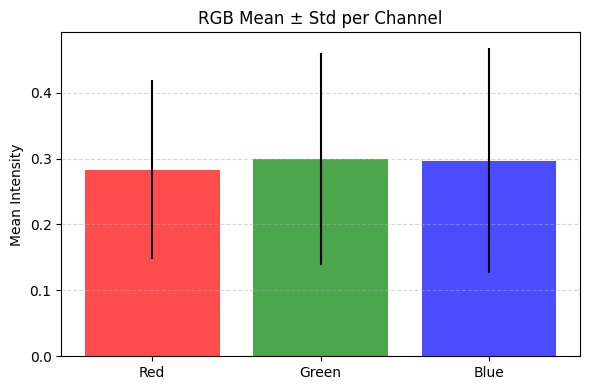

In [22]:
# --- Arrays to store RGB means ---
rgb_means = []
sample_images = np.random.choice(all_train_images, size=min(1000, len(all_train_images)), replace=False)
for img_name in sample_images:
    img_path = os.path.join(IMAGE_DIR_TRAIN, img_name)
    if os.path.exists(img_path):
        img = Image.open(img_path).convert("RGB")
        arr = np.array(img) / 255.0  # normalize to 0-1
        mean_rgb = arr.mean(axis=(0, 1))
        rgb_means.append(mean_rgb)

rgb_means = np.array(rgb_means)
rgb_mean = rgb_means.mean(axis=0)
rgb_std = rgb_means.std(axis=0)

print("RGB Mean:", rgb_mean)
print("RGB Std:", rgb_std)

# --- Plot RGB means ---
plt.figure(figsize=(6,4))
plt.bar(['Red', 'Green', 'Blue'], rgb_mean, yerr=rgb_std, color=['r','g','b'], alpha=0.7)
plt.ylabel("Mean Intensity")
plt.title("RGB Mean ± Std per Channel")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "rgb_mean_plot.png"))
plt.show()

RGB Mean: [0.2797509  0.29447165 0.29285817]
RGB Std: [0.13423997 0.15974185 0.17089041]


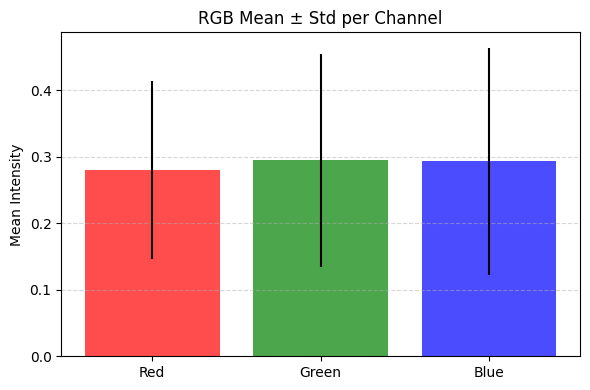

In [23]:
# --- Arrays to store RGB means ---
rgb_means = []
sample_images = np.random.choice(all_val_images, size=min(1000, len(all_train_images)), replace=False)
for img_name in sample_images:
    img_path = os.path.join(IMAGE_DIR_VAL, img_name)
    if os.path.exists(img_path):
        img = Image.open(img_path).convert("RGB")
        arr = np.array(img) / 255.0  # normalize to 0-1
        mean_rgb = arr.mean(axis=(0, 1))
        rgb_means.append(mean_rgb)

rgb_means = np.array(rgb_means)
rgb_mean = rgb_means.mean(axis=0)
rgb_std = rgb_means.std(axis=0)

print("RGB Mean:", rgb_mean)
print("RGB Std:", rgb_std)

# --- Plot RGB means ---
plt.figure(figsize=(6,4))
plt.bar(['Red', 'Green', 'Blue'], rgb_mean, yerr=rgb_std, color=['r','g','b'], alpha=0.7)
plt.ylabel("Mean Intensity")
plt.title("RGB Mean ± Std per Channel")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "rgb_mean_plot_val.png"))
plt.show()

# Duplicate and Corrupted Image Analysis

In [24]:


corrupted_files = 0
duplicate_count = 0
missing_files = 0
hash_dict = defaultdict(list)

for img_name in all_train_images:
    img_path = os.path.join(IMAGE_DIR_TRAIN, img_name)
    
    if not os.path.exists(img_path):
        print(f"Missing: {img_name}")
        missing_files += 1
        continue

    try:
        with Image.open(img_path) as img:
            img.load()
            img_hash = str(imagehash.average_hash(img))
            hash_dict[img_hash].append(img_name)
    except (UnidentifiedImageError, OSError) as e:
        print(f"Corrupted: {img_name} ({e})")
        corrupted_files += 1

# Now analyze duplicates
duplicates = {h: names for h, names in hash_dict.items() if len(names) > 1}
duplicate_count = sum(len(v) - 1 for v in duplicates.values())

print("\n Summary:")
print(f"Missing Files: {missing_files}")
print(f"Corrupted Files: {corrupted_files}")
print(f"Duplicate Groups: {len(duplicates)}")
print(f"Duplicate Images (total extra files): {duplicate_count}")

# 🧩 Show sample duplicate sets
print("\n Example Duplicate Groups:")
for i, (h, names) in enumerate(duplicates.items()):
    print(f"\nGroup {i+1} (hash={h}):")
    for n in names:
        print(f"  - {n}")
    if i >= 4:  # show first 5 groups only
        break



 Summary:
Missing Files: 0
Corrupted Files: 0
Duplicate Groups: 493
Duplicate Images (total extra files): 1083

 Example Duplicate Groups:

Group 1 (hash=ffffffc000000000):
  - 0000f77c-62c2a288.jpg
  - 05ca0197-6c0b4628.jpg
  - 27177a04-4e9fa0cf.jpg
  - 9392f6f6-f4d5c55c.jpg
  - a02c5f81-f4cc9b8d.jpg

Group 2 (hash=fcfcfc1800000000):
  - 000d4f89-3bcbe37a.jpg
  - 5c0e41f0-0f8ca6f3.jpg

Group 3 (hash=ffffff0800000000):
  - 0024b742-83709bd4.jpg
  - 191e2dd9-b6147847.jpg
  - 45af8b22-3054b5f0.jpg
  - 6ce5d138-b7ab8ebf.jpg
  - adfc8f5c-8bd2f72d.jpg

Group 4 (hash=ffffffff03000000):
  - 002e6895-442e6bc1.jpg
  - 6f408535-796ac797.jpg

Group 5 (hash=fefffffe00000000):
  - 007da0eb-8cca23d7.jpg
  - 2ce0b449-21052ede.jpg
  - 98dc67a8-aad370c7.jpg


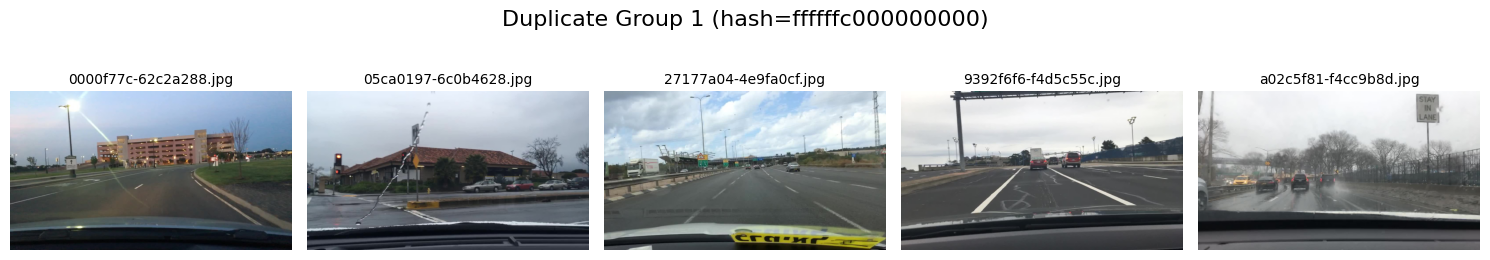

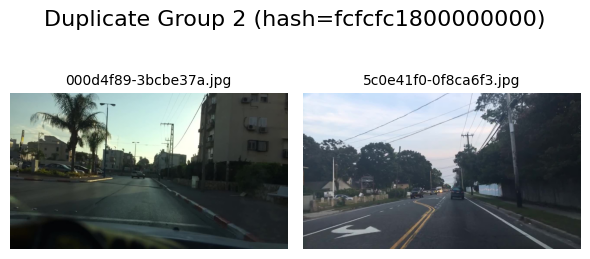

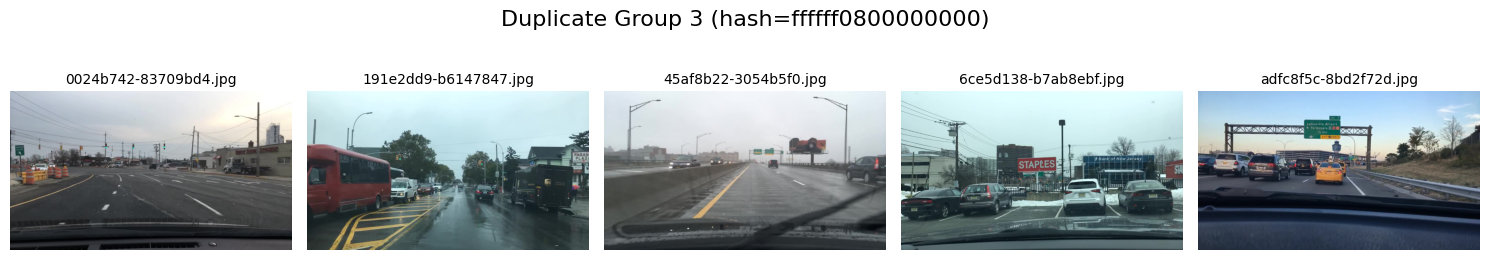

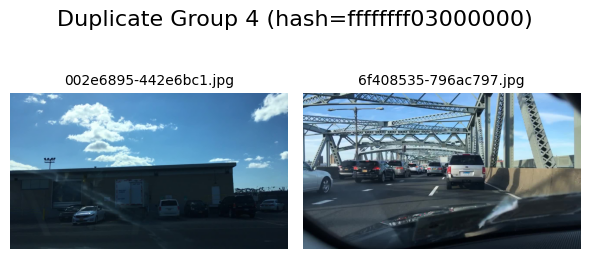

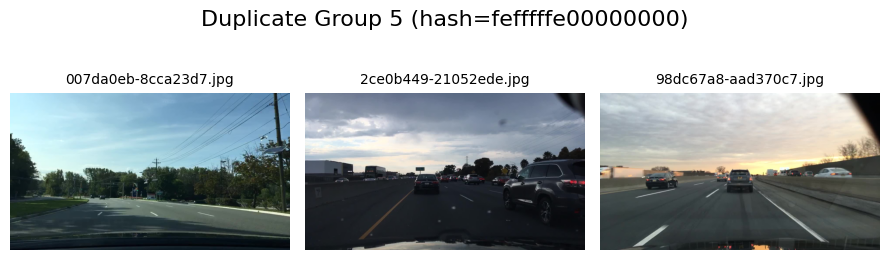

In [25]:


# Number of duplicate groups to visualize
num_groups_to_show = 5

for i, (h, names) in enumerate(duplicates.items()):
    if i >= num_groups_to_show:
        break

    n_images = len(names)
    plt.figure(figsize=(3*n_images, 3))
    plt.suptitle(f"Duplicate Group {i+1} (hash={h})", fontsize=16)

    for j, img_name in enumerate(names):
        img_path = os.path.join(IMAGE_DIR_TRAIN, img_name)
        try:
            with Image.open(img_path) as img:
                plt.subplot(1, n_images, j+1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(img_name, fontsize=10)
        except Exception as e:
            print(f"Could not open {img_name}: {e}")

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, f"duplicate_group_{i+1}.png"))
    plt.show()


In [26]:

corrupted_files = 0
duplicate_count = 0
missing_files = 0
hash_dict = defaultdict(list)

for img_name in all_val_images:
    img_path = os.path.join(IMAGE_DIR_VAL, img_name)
    
    if not os.path.exists(img_path):
        print(f"Missing: {img_name}")
        missing_files += 1
        continue

    try:
        with Image.open(img_path) as img:
            img.load()
            img_hash = str(imagehash.average_hash(img))
            hash_dict[img_hash].append(img_name)
    except (UnidentifiedImageError, OSError) as e:
        print(f"Corrupted: {img_name} ({e})")
        corrupted_files += 1

# Now analyze duplicates
duplicates = {h: names for h, names in hash_dict.items() if len(names) > 1}
duplicate_count = sum(len(v) - 1 for v in duplicates.values())

print("\n Summary:")
print(f"Missing Files: {missing_files}")
print(f"Corrupted Files: {corrupted_files}")
print(f"Duplicate Groups: {len(duplicates)}")
print(f"Duplicate Images (total extra files): {duplicate_count}")

# 🧩 Show sample duplicate sets
print("\n Example Duplicate Groups:")
for i, (h, names) in enumerate(duplicates.items()):
    print(f"\nGroup {i+1} (hash={h}):")
    for n in names:
        print(f"  - {n}")
    if i >= 4:  # show first 5 groups only
        break



 Summary:
Missing Files: 0
Corrupted Files: 0
Duplicate Groups: 37
Duplicate Images (total extra files): 56

 Example Duplicate Groups:

Group 1 (hash=ffffff1e00000000):
  - b1d10d08-c35503b8.jpg
  - bd46bba0-fadf1d6d.jpg

Group 2 (hash=ffffffff00000000):
  - b1e9ee0e-67e26f2e.jpg
  - b7e8932c-3f90dbfc.jpg
  - baa255c5-5c99a79a.jpg
  - bd1e9944-4fd7ac70.jpg
  - be791a81-a6b53fef.jpg
  - c18df454-acb6d4fa.jpg
  - ca2bcf0e-69e964d2.jpg

Group 3 (hash=fffffff000000000):
  - b20d494a-cdebe83e.jpg
  - c8e8cd4a-9dd5daeb.jpg

Group 4 (hash=fffffffe00000000):
  - b251064f-30002542.jpg
  - b255cd6c-bc3cbb18.jpg
  - bda1cdfa-5da26736.jpg
  - c6ca7b50-4238e038.jpg
  - c8638ebb-5dc7483b.jpg

Group 5 (hash=f8f8f8f000000000):
  - b251064f-8d92db81.jpg
  - bd998983-63d9420a.jpg
  - c239ab3d-61c3912f.jpg


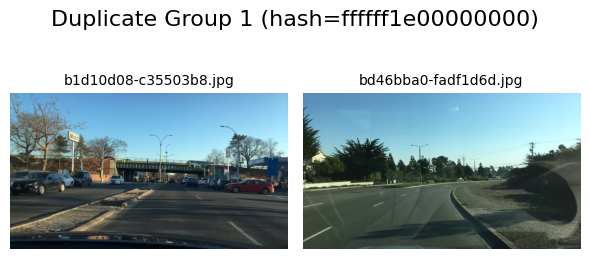

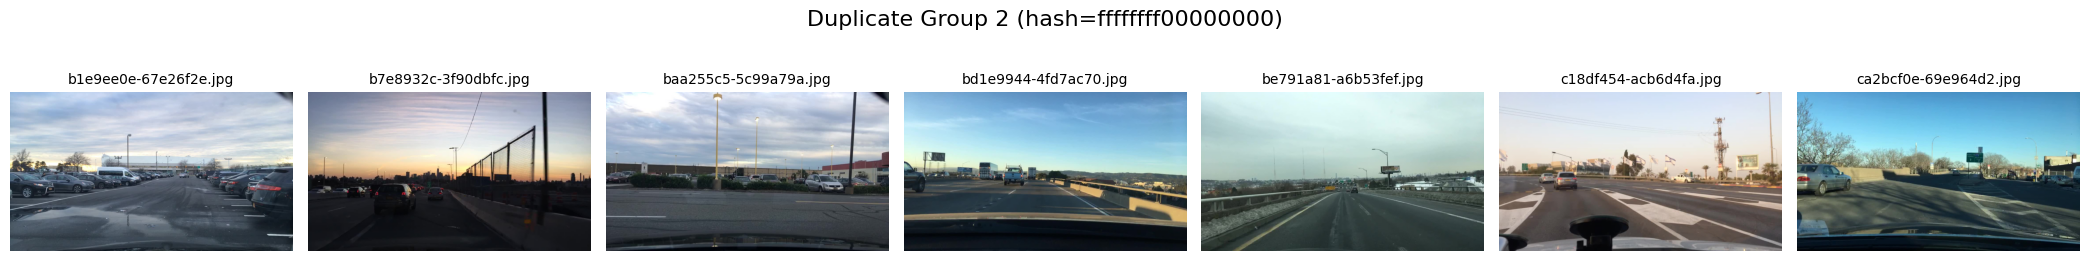

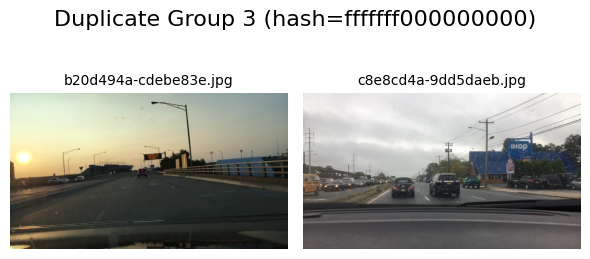

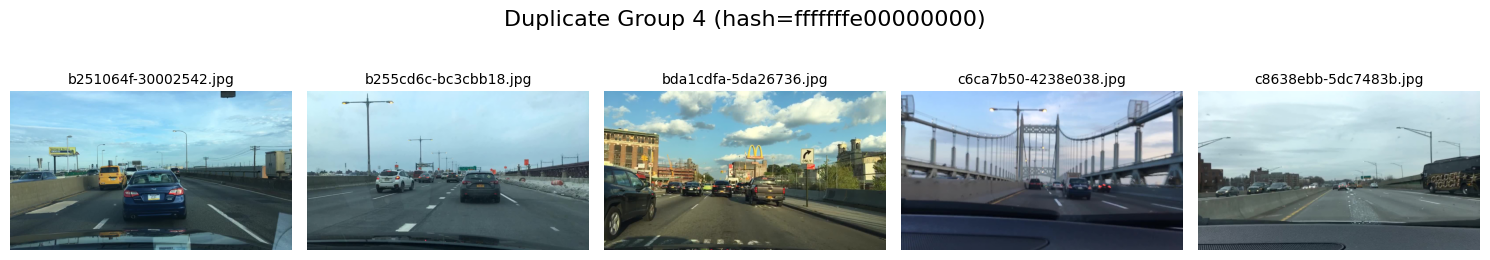

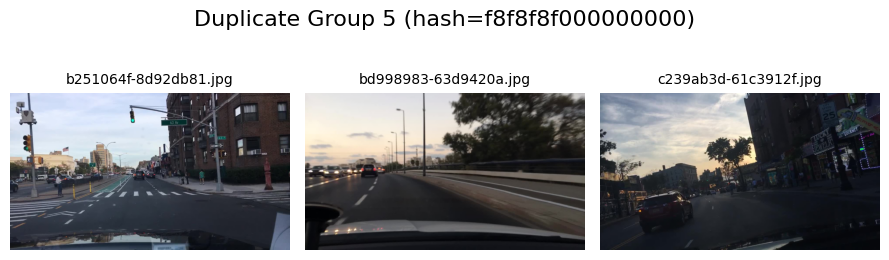

In [27]:


# Number of duplicate groups to visualize
num_groups_to_show = 5

for i, (h, names) in enumerate(duplicates.items()):
    if i >= num_groups_to_show:
        break

    n_images = len(names)
    plt.figure(figsize=(3*n_images, 3))
    plt.suptitle(f"Duplicate Group {i+1} (hash={h})", fontsize=16)

    for j, img_name in enumerate(names):
        img_path = os.path.join(IMAGE_DIR_VAL, img_name)
        try:
            with Image.open(img_path) as img:
                plt.subplot(1, n_images, j+1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(img_name, fontsize=10)
        except Exception as e:
            print(f"Could not open {img_name}: {e}")

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, f"duplicate_group_val_{i+1}.png"))
    plt.show()


# Annotations Analysis

In [28]:
def preprocess_annotations(labels):
    """Extracts per-image statistics from annotations."""
    data_stats = {
        "image_name":[],
        "class_counter": Counter(),
        "box_areas": [],
        "aspect_ratios": [],
        "objects_per_image": [],
        "object_centers": [],
        "timeofday_counter": Counter(),
        "weather_counter": Counter(),
        "scene_counter": Counter(),
        "scene_object_counter": defaultdict(Counter)
    }
    
    for ann in labels:
        objects = ann.get("labels", [])
        n_objects = len(objects)
        data_stats["objects_per_image"].append(n_objects)
        data_stats["image_name"].append(ann.get("name",[]))

        for obj in objects:
            cls = obj.get("category")
            data_stats["class_counter"][cls] += 1

            # Bounding box stats
            box = obj.get("box2d")
            if box:
                x1, y1 = box["x1"], box["y1"]
                x2, y2 = box["x2"], box["y2"]
                w, h = x2 - x1, y2 - y1
                area = w * h
                aspect_ratio = w / h if h != 0 else 0
                data_stats["box_areas"].append(area)
                data_stats["aspect_ratios"].append(aspect_ratio)
                center = ((x1 + x2)/2, (y1 + y2)/2)
                data_stats["object_centers"].append(center)

        # Scene-level attributes
        attrs = ann.get("attributes", {})
        timeofday = attrs.get("timeofday")
        weather = attrs.get("weather")
        scene = attrs.get("scene")

        if timeofday:
            data_stats["timeofday_counter"][timeofday] += 1
        if weather:
            data_stats["weather_counter"][weather] += 1
        if scene:
            data_stats["scene_counter"][scene] += 1
            for obj in objects:
                data_stats["scene_object_counter"][scene][obj.get("category")] += 1

    # Convert lists to numpy arrays for easy statistics
    data_stats["box_areas"] = np.array(data_stats["box_areas"])
    data_stats["aspect_ratios"] = np.array(data_stats["aspect_ratios"])
    data_stats["objects_per_image"] = np.array(data_stats["objects_per_image"])
    data_stats["object_centers"] = np.array(data_stats["object_centers"])

    return data_stats


# --- Preprocess train and val ---
train_stats = preprocess_annotations(train_labels)
val_stats   = preprocess_annotations(val_labels)


In [29]:
def save_extreme_boxes(images, labels, image_dir, save_dir, num_examples=5):
    os.makedirs(save_dir, exist_ok=True)

    # Collect all boxes with their areas
    all_boxes = []
    for ann in labels:
        img_name = ann["name"]
        for obj in ann.get("labels", []):
            if "box2d" in obj:
                box = obj["box2d"]
                area = (box["x2"] - box["x1"]) * (box["y2"] - box["y1"])
                all_boxes.append({
                    "img_name": img_name,
                    "box": box,
                    "area": area,
                    "category": obj["category"]
                })

    # Sort boxes by area
    sorted_boxes = sorted(all_boxes, key=lambda x: x["area"])
    
    # Smallest and largest
    extremes = {
        'smallest': sorted_boxes[:num_examples],
        'largest': sorted_boxes[-num_examples:]
    }

    for key, items in extremes.items():
        for idx, item in enumerate(items):
            img_path = os.path.join(image_dir, item["img_name"])
            with Image.open(img_path) as img:
                draw_img = img.copy()
                draw = ImageDraw.Draw(draw_img)
                box = item["box"]
                color = "red" if key == 'smallest' else "green"
                draw.rectangle([box["x1"], box["y1"], box["x2"], box["y2"]], outline=color, width=5)
                
                # Add text
                text = f"{item['category']} | Area: {item['area']:.2f}"
                try:
                    font = ImageFont.truetype("arial.ttf", 20)
                except:
                    font = ImageFont.load_default()
                draw.text((box["x1"], max(box["y1"]-25,0)), text, fill=color, font=font)

                # Save
                save_path = os.path.join(save_dir, f"{key}_{idx+1}_{item['img_name']}")
                draw_img.save(save_path)
                print(f"Saved: {save_path}")

# Example usage
save_extreme_boxes(all_train_images, train_labels, IMAGE_DIR_TRAIN, save_dir="results/extreme_boxes", num_examples=5)


Saved: results/extreme_boxes/smallest_1_20a773e1-a9268e6b.jpg
Saved: results/extreme_boxes/smallest_2_7bc6abdd-6a5c7b75.jpg
Saved: results/extreme_boxes/smallest_3_3bb2f5c2-1463d3a1.jpg
Saved: results/extreme_boxes/smallest_4_a34c36f3-22c7e2c3.jpg
Saved: results/extreme_boxes/smallest_5_84643961-e2e4a747.jpg
Saved: results/extreme_boxes/largest_1_414fe350-4f0f6e64.jpg
Saved: results/extreme_boxes/largest_2_70cc96e1-aa1781b5.jpg
Saved: results/extreme_boxes/largest_3_4efe84c6-93313761.jpg
Saved: results/extreme_boxes/largest_4_2e5a3ced-c7603d0d.jpg
Saved: results/extreme_boxes/largest_5_1d33c83b-71e1ea1c.jpg


In [30]:
# Sort annotations by object count descending
top5_idx = np.argsort(-train_stats["objects_per_image"])[:5]

plt.figure(figsize=(20,8))
for i, idx in enumerate(top5_idx):
    ann = train_labels[idx]
    img_path = os.path.join(IMAGE_DIR_TRAIN, ann["name"])
    with Image.open(img_path) as img:
        draw = ImageDraw.Draw(img)
        for obj in ann.get("labels", []):
            box = obj.get("box2d")
            if box:
                draw.rectangle([box["x1"], box["y1"], box["x2"], box["y2"]], outline="red", width=2)

        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{ann['name']}\nObjects: {train_stats['objects_per_image'][idx]}", fontsize=10)

plt.tight_layout()

# ✅ Save the figure
output_path = "results/top5_crowded_images_train.png"
plt.savefig(output_path)
plt.close()

print(f"Top 5 crowded images saved to {output_path}")


Top 5 crowded images saved to results/top5_crowded_images_train.png


In [31]:
# -------------------------
# --- Plotting Functions ---
# -------------------------

def plot_class_distribution(counter, filename):
    plt.figure(figsize=(10,5))
    sns.barplot(x=list(counter.keys()), y=list(counter.values()))
    plt.xticks(rotation=45)
    plt.title("Class Distribution")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

def plot_box_area_hist(box_areas, filename):
    plt.figure(figsize=(8,5))
    plt.hist(box_areas, bins=50, alpha=0.7)
    plt.title("Box Area Distribution")
    plt.xlabel("Area (pixels^2)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

def plot_aspect_ratio_hist(aspect_ratios, filename):
    plt.figure(figsize=(8,5))
    plt.hist(aspect_ratios, bins=50, alpha=0.7)
    plt.title("Aspect Ratio Distribution")
    plt.xlabel("Width / Height")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

def plot_objects_per_image(objects_per_image, filename):
    plt.figure(figsize=(8,5))
    plt.hist(objects_per_image, bins=50, alpha=0.7)
    plt.title("Objects per Image")
    plt.xlabel("Number of Objects")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

def plot_object_center_heatmap(centers, filename, img_width=1280, img_height=720):
    plt.figure(figsize=(8,6))
    if len(centers) > 0:
        x, y = centers[:,0], centers[:,1]
        plt.hist2d(x, y, bins=[50, 50], range=[[0, img_width], [0, img_height]], cmap='Reds')
        plt.colorbar(label='Count')
        plt.gca().invert_yaxis()
    plt.title("Object Centers Heatmap")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

def plot_attribute_distribution(counter, title, filename):
    plt.figure(figsize=(6,4))
    sns.barplot(x=list(counter.keys()), y=list(counter.values()))
    plt.title(title)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

def plot_scene_object_corr(scene_obj_counter, filename):
    scenes = list(scene_obj_counter.keys())
    classes = set()
    for c in scene_obj_counter.values():
        classes.update(c.keys())
    classes = sorted(classes)

    data = np.zeros((len(scenes), len(classes)))
    for i, s in enumerate(scenes):
        for j, c in enumerate(classes):
            data[i,j] = scene_obj_counter[s][c]

    plt.figure(figsize=(10,6))
    sns.heatmap(data, xticklabels=classes, yticklabels=scenes, cmap="Reds", annot=True, fmt='g')
    plt.title("Scene-Object Correlation")
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()



In [32]:
timeofday_counter = train_stats["timeofday_counter"]
total_images = sum(timeofday_counter.values())

timeofday_table = []
for time in ["daytime", "night", "dawn/dusk"]:
    count = timeofday_counter.get(time, 0)
    pct = (count / total_images) * 100 if total_images > 0 else 0
    timeofday_table.append((time.capitalize(), count, f"{pct:.1f}%"))

# Print table
print("| Time | Count | % |")
print("|:-----|------:|--:|")
for row in timeofday_table:
    print(f"| {row[0]} | {row[1]} | {row[2]} |")

| Time | Count | % |
|:-----|------:|--:|
| Daytime | 36728 | 52.6% |
| Night | 27971 | 40.0% |
| Dawn/dusk | 5027 | 7.2% |


In [33]:
# --- 5.2 Weather Conditions ---
weather_counter = train_stats["weather_counter"]
total_images = sum(weather_counter.values())

weather_table = []
for weather in ["clear", "rainy", "foggy", "snowy"]:
    count = weather_counter.get(weather, 0)
    pct = (count / total_images) * 100 if total_images > 0 else 0
    weather_table.append((weather.title(), count, f"{pct:.1f}%"))

print("### 5.2 Weather Conditions")
print("![Weather Distribution](results/weather_distribution_train.png)\n")
print("| Weather | Count | % |")
print("|:--------|------:|--:|")
for row in weather_table:
    print(f"| {row[0]} | {row[1]} | {row[2]} |")


### 5.2 Weather Conditions
![Weather Distribution](results/weather_distribution_train.png)

| Weather | Count | % |
|:--------|------:|--:|
| Clear | 37344 | 53.5% |
| Rainy | 5070 | 7.3% |
| Foggy | 130 | 0.2% |
| Snowy | 5549 | 7.9% |


In [34]:


# --- 5.3 Scene Types ---
scene_counter = train_stats["scene_counter"]
total_images = sum(scene_counter.values())

scene_table = []
for scene in ["city street", "highway", "residential"]:
    count = scene_counter.get(scene, 0)
    pct = (count / total_images) * 100 if total_images > 0 else 0
    scene_table.append((scene.title(), count, f"{pct:.1f}%"))

print("### 5.3 Scene Types")
print("![Scene Distribution](results/scene_distribution.png)\n")
print("| Scene | Count | % |")
print("|:------|------:|--:|")
for row in scene_table:
    print(f"| {row[0]} | {row[1]} | {row[2]} |")

print("\n---\n")

# --- 5.4 Scene-Object Correlation ---
scene_object_counter = train_stats["scene_object_counter"]

print("### 5.4 Correlation between Scene & Object Types")
print("![Scene-Object Correlation Heatmap](results/scene_object_corr.png)\n")
print("> _Interpret patterns (e.g., trucks mainly appear on highways)._")
print("\n---\n")

# --- 6. Train-Test Split Validation ---
train_images_count = len(train_labels)
val_images_count = len(val_labels)
# Sum total objects
train_objects_count = sum(train_stats["objects_per_image"])
val_objects_count = sum(val_stats["objects_per_image"])

print("## 6. 🔍 Train-Test Split Validation\n")
print("| Split | #Images | #Objects | Note |")
print("|:------|---------:|---------:|:-----|")
print(f"| Train | {train_images_count} | {train_objects_count} |  |")
print(f"| Val   | {val_images_count} | {val_objects_count} |  |")
# Test data can be added if available
print(f"| Test  | [ ] | [ ] |  |")


### 5.3 Scene Types
![Scene Distribution](results/scene_distribution.png)

| Scene | Count | % |
|:------|------:|--:|
| City Street | 43516 | 62.3% |
| Highway | 17379 | 24.9% |
| Residential | 8074 | 11.6% |

---

### 5.4 Correlation between Scene & Object Types
![Scene-Object Correlation Heatmap](results/scene_object_corr.png)

> _Interpret patterns (e.g., trucks mainly appear on highways)._

---

## 6. 🔍 Train-Test Split Validation

| Split | #Images | #Objects | Note |
|:------|---------:|---------:|:-----|
| Train | 69863 | 1941237 |  |
| Val   | 10000 | 279237 |  |
| Test  | [ ] | [ ] |  |


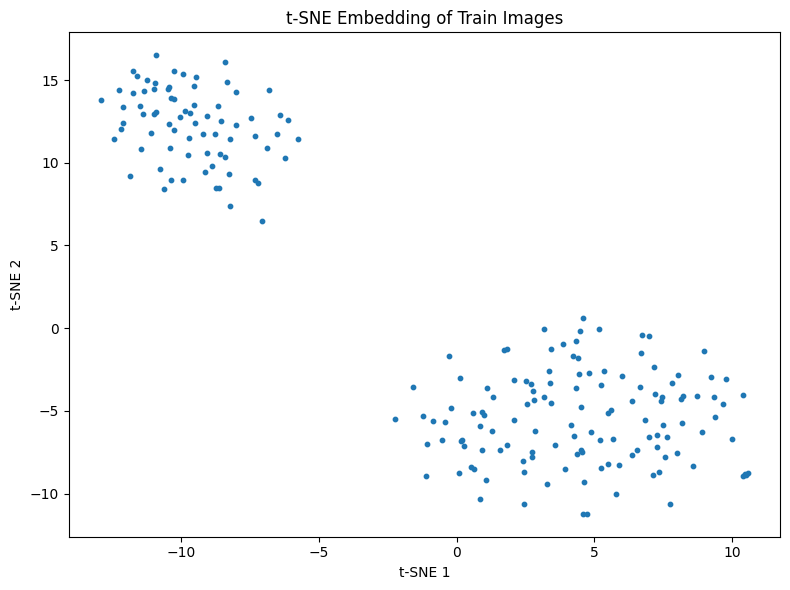

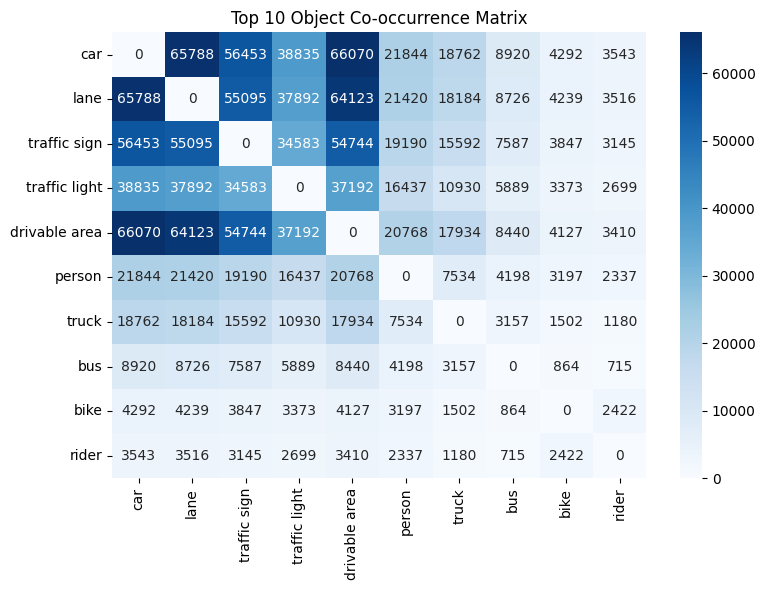

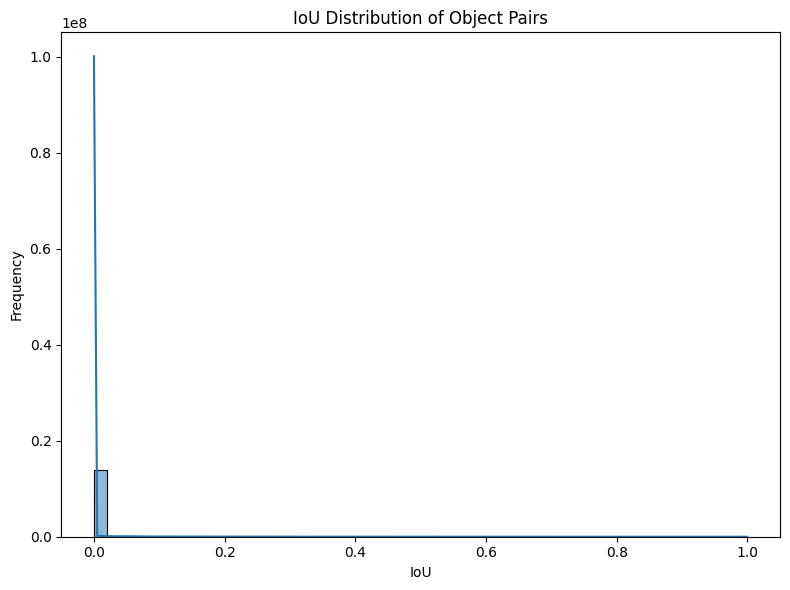

In [35]:


# --- 8.1 Image Embedding Clustering (PCA / t-SNE) ---

def extract_image_features(image_paths, image_dir, size=(64, 64)):
    """Convert images to flattened grayscale vectors for clustering."""
    features = []
    for img_name in image_paths:
        img_path = os.path.join(image_dir, img_name)
        try:
            with Image.open(img_path) as img:
                img = img.convert('L').resize(size)
                features.append(np.array(img).flatten() / 255.0)
        except:
            continue
    return np.array(features)

# Example: t-SNE on first 200 images (can increase later)
train_img_paths = [ann["name"] for ann in train_labels][:200]
features = extract_image_features(train_img_paths, IMAGE_DIR_TRAIN)

# PCA for initial dimensionality reduction
pca = PCA(n_components=50)
features_pca = pca.fit_transform(features)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(features_pca)

plt.figure(figsize=(8,6))
plt.scatter(features_tsne[:,0], features_tsne[:,1], s=10)
plt.title("t-SNE Embedding of Train Images")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.savefig("results/tsne_clusters.png")
plt.show()

# --- 8.2 Object Co-occurrence Matrix ---

# Count co-occurrence of object pairs per image
co_occurrence = Counter()
for ann in train_labels:
    objs = [obj["category"] for obj in ann.get("labels", [])]
    for pair in combinations(sorted(set(objs)), 2):
        co_occurrence[pair] += 1

# Create a matrix for top 10 objects
top_objects = [obj for obj, _ in train_stats["class_counter"].most_common(10)]
matrix = np.zeros((len(top_objects), len(top_objects)), dtype=int)
for i, obj1 in enumerate(top_objects):
    for j, obj2 in enumerate(top_objects):
        if obj1 != obj2:
            matrix[i,j] = co_occurrence.get(tuple(sorted([obj1,obj2])), 0)

plt.figure(figsize=(8,6))
sns.heatmap(matrix, xticklabels=top_objects, yticklabels=top_objects, annot=True, fmt="d", cmap="Blues")
plt.title("Top 10 Object Co-occurrence Matrix")
plt.tight_layout()
plt.savefig("results/cooccurrence_matrix.png")
plt.show()

# --- 8.3 IoU Overlaps / Crowding Density ---

def compute_iou(box1, box2):
    """Compute IoU between two boxes."""
    x1 = max(box1["x1"], box2["x1"])
    y1 = max(box1["y1"], box2["y1"])
    x2 = min(box1["x2"], box2["x2"])
    y2 = min(box1["y2"], box2["y2"])
    inter_w = max(0, x2 - x1)
    inter_h = max(0, y2 - y1)
    inter_area = inter_w * inter_h
    area1 = (box1["x2"] - box1["x1"]) * (box1["y2"] - box1["y1"])
    area2 = (box2["x2"] - box2["x1"]) * (box2["y2"] - box2["y1"])
    union_area = area1 + area2 - inter_area
    return inter_area / union_area if union_area > 0 else 0

iou_list = []
for ann in train_labels:
    boxes = [obj["box2d"] for obj in ann.get("labels", []) if "box2d" in obj]
    for i in range(len(boxes)):
        for j in range(i+1, len(boxes)):
            iou = compute_iou(boxes[i], boxes[j])
            iou_list.append(iou)

plt.figure(figsize=(8,6))
sns.histplot(iou_list, bins=50, kde=True)
plt.title("IoU Distribution of Object Pairs")
plt.xlabel("IoU")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("results/iou_density_plot.png")
plt.show()


# Generate Plots

In [36]:
# Class Distribution
plot_class_distribution(train_stats["class_counter"], os.path.join(RESULTS_DIR, "class_distribution_train.png"))
plot_class_distribution(val_stats["class_counter"], os.path.join(RESULTS_DIR, "class_distribution_val.png"))

In [37]:
# Box Area & Aspect Ratio
plot_box_area_hist(train_stats["box_areas"], os.path.join(RESULTS_DIR, "box_area_hist_train.png"))
plot_aspect_ratio_hist(train_stats["aspect_ratios"], os.path.join(RESULTS_DIR, "aspect_ratio_hist_train.png"))

In [38]:
# Objects per image
plot_objects_per_image(train_stats["objects_per_image"], os.path.join(RESULTS_DIR, "objects_per_image_train.png"))

In [39]:
# Object centers heatmap
plot_object_center_heatmap(train_stats["object_centers"], os.path.join(RESULTS_DIR, "object_heatmap_train.png"))

In [40]:
# Time of day / weather / scene
plot_attribute_distribution(train_stats["timeofday_counter"], "Time of Day Distribution", os.path.join(RESULTS_DIR, "timeofday_distribution_train.png"))
plot_attribute_distribution(train_stats["weather_counter"], "Weather Distribution", os.path.join(RESULTS_DIR, "weather_distribution_train.png"))
plot_attribute_distribution(train_stats["scene_counter"], "Scene Distribution", os.path.join(RESULTS_DIR, "scene_distribution_train.png"))

In [41]:
# Scene-object correlation
plot_scene_object_corr(train_stats["scene_object_counter"], os.path.join(RESULTS_DIR, "scene_object_corr_train.png"))

In [43]:
# -------------------------
# --- Train-Val Comparison ---
# -------------------------
def compare_class_distribution(train_counter, val_counter, filename):
    classes = sorted(set(train_counter.keys()) | set(val_counter.keys()))
    train_counts = [train_counter.get(c, 0) for c in classes]
    val_counts = [val_counter.get(c, 0) for c in classes]

    x = np.arange(len(classes))
    width = 0.35
    plt.figure(figsize=(12,5))
    plt.bar(x - width/2, train_counts, width, label='Train')
    plt.bar(x + width/2, val_counts, width, label='Val')
    plt.xticks(x, classes, rotation=45)
    plt.ylabel("Count")
    plt.title("Class Distribution: Train vs Val")
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

compare_class_distribution(train_stats["class_counter"], val_stats["class_counter"], os.path.join(RESULTS_DIR, "train_val_class_balance.png"))